In [ ]:
#%pip install Unidecode
#%pip install num2words
#%pip install spacy
#%pip install stanza

# Imports
Son las instalaciones necesarias para la preparacion de datos y la ejecucion del proyecto

Aqui importamos las librerias necesarias y se descarga el modelo en español de stanza.
Stanza es una colección de herramientas precisas y eficientes para el análisis lingüístico de muchos lenguajes humanos. A partir del texto sin formato, Stanza lo divide en oraciones y palabras, y luego puede reconocer partes del discurso y entidades, realizar análisis sintácticos y más.

In [ ]:
import pandas as pd
import re
from unidecode import unidecode
import num2words
import spacy
from spacy.lang.es import stop_words as stop_words
import stanza


In [17]:
#stanza.download("es")

# Carga de datos

In [ ]:
df=pd.read_csv('fake_news_spanish.csv', encoding='utf-8', delimiter=';')
df

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


In [ ]:
# verificamos si hay valores nulos
df.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [ ]:
# corregimos los valores nulos y unimos las columnas 'Titulo' y 'Descripcion'
df['Titulo']=df['Titulo'].fillna('')
df['preparados']=df['Titulo']+df['Descripcion']
df


,ID,Label,Titulo,Descripcion,Fecha,preparados
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,'The Guardian' va con Sánchez: 'Europa necesit...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,Puigdemont: 'No sería ninguna tragedia una rep...
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,El Defensor del Pueblo reclama a la Comunidad ...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,El EQUO plantea ceder la presidencia de la Com...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,Alberto Garzón: 'Que los Borbones son unos lad...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,Vox exige entrar en el Gobierno de Castilla y ...


# Perfilamiento de datos

In [21]:
df['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [ ]:
# chart de la distribución de las etiquetas
#df.groupby('Label').value_counts().plot(kind='bar', y = 'Label')

Observamos que hay una distribución poco equitativa de datos

# Preparación de los datos

Se uso la libreria de stanza para tokenizar y lemmatizar la columan 'preparados' del dataframe, debido a que este proceso se demora alrededor de una hora o más y es una cantidad excesiva de tiempo decidimos hacer una primera limpieza de los datos y exportarlo a un csv.

Definimos la funcion de normalizar texto para eliminar caracteres invalidos en unidecode

In [ ]:
def normalizar(texto):
    # todo a minúsculas
    texto = texto.lower()

    # tildes y diacríticas
    texto = unidecode(texto)

    return texto

df['preparados'] = df['preparados'].apply(normalizar)
df['preparados']


0        ' the guardian ' ir con sanchez : ' europa nec...
1        revelan que el gobierno negocio el liberacion ...
2        el ' ahora o nunca ' de joan fuster sobre el e...
3        iglesias alentar a yolanda diaz , erc y eh bil...
4        puigdemont : ' no ser ninguno tragedia uno rep...
                               ...                        
57058    el defensor del pueblo reclamar a el comunidad...
57059    el equo plantear ceder el presidencia de el co...
57060    alberto garzon : ' que el borbones ser uno lad...
57061    vox exigir entrar en el gobierno de castilla y...
57062    uno 300 persona protestar contra el visita del...
Name: preparados, Length: 57063, dtype: object

In [ ]:
def tokenizar(texto):
    # dividir el texto en palabras
    palabras = re.findall(r'\b\w+\b', texto)
    return palabras

df['preparados']=df['preparados'].apply(tokenizar)
df['preparados']

0        [the, guardian, ir, con, sanchez, europa, nece...
1        [revelan, que, el, gobierno, negocio, el, libe...
2        [el, ahora, o, nunca, de, joan, fuster, sobre,...
3        [iglesias, alentar, a, yolanda, diaz, erc, y, ...
4        [puigdemont, no, ser, ninguno, tragedia, uno, ...
                               ...                        
57058    [el, defensor, del, pueblo, reclamar, a, el, c...
57059    [el, equo, plantear, ceder, el, presidencia, d...
57060    [alberto, garzon, que, el, borbones, ser, uno,...
57061    [vox, exigir, entrar, en, el, gobierno, de, ca...
57062    [uno, 300, persona, protestar, contra, el, vis...
Name: preparados, Length: 57063, dtype: object

In [ ]:
stopwords_espanol = stop_words.STOP_WORDS
#Se usa Spacy porque tiene un "vocabulario" más amplio que NLTK
#Genera un mejor resultado debido a esto

def stopwords_espanol_remove(line):
    new_line=[]
    for word in line:
        if word not in stopwords_espanol:
            new_line.append(word)
    return new_line


df['preparados']=df['preparados'].apply(stopwords_espanol_remove)
df['preparados']

0        [the, guardian, sanchez, europa, necesitar, ap...
1        [revelan, gobierno, negocio, liberacion, mirel...
2        [joan, fuster, estatuto, valenciano, cumplir, ...
3        [iglesias, alentar, yolanda, diaz, erc, eh, bi...
4        [puigdemont, tragedia, repeticion, elecciones,...
                               ...                        
57058    [defensor, pueblo, reclamar, comunidad, madrid...
57059    [equo, plantear, ceder, presidencia, comunidad...
57060    [alberto, garzon, borbones, ladron, historicam...
57061    [vox, exigir, entrar, gobierno, castilla, leon...
57062    [300, persona, protestar, visita, rey, barcelo...
Name: preparados, Length: 57063, dtype: object

In [ ]:
def num_to_word(line):
    new_line=[]

    for word in line:
        if re.fullmatch(r'\d+',word):
            word=float(word)
            new_line.append(num2words.num2words(word, lang = 'es_CO'))
        else:
            new_line.append(word)
    return new_line

df['preparados']=df['preparados'].apply(num_to_word)
df

In [ ]:
df['tamanio']=df['preparados'].apply(len)

# Alternativa + leming

In [22]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2025-02-20 22:43:24 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-20 22:43:24 INFO: Downloaded file to C:\Users\juand\stanza_resources\resources.json
2025-02-20 22:43:26 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2025-02-20 22:43:26 INFO: Using device: cpu
2025-02-20 22:43:26 INFO: Loading: tokenize
2025-02-20 22:43:29 INFO: Loading: mwt
2025-02-20 22:43:29 INFO: Loading: pos
2025-02-20 22:43:38 INFO: Loading: lemma
2025-02-20 22:43:41 INFO: Done loading processors!


In [23]:
nlp = spacy.load('es_core_news_sm')

In [ ]:
def lemmatizer(text):  
  doc = nlp(text)
  return [word.lemma_ for word in doc]

In [ ]:
df['preparados']=df['preparados'].apply(lemmatizer)
df['preparados']

0        ' The Guardian ' ir con Sánchez : ' Europa nec...
1        revelan QUE el GOBIERNO NEGOCIO el liberación ...
2        el ' ahora o nunca ' de Joan Fuster sobre el e...
3        Iglesias alentar a Yolanda Díaz , ERC y EH Bil...
4        Puigdemont : ' no ser ninguno tragedia uno rep...
                               ...                        
57058    el Defensor del Pueblo reclamar a el Comunidad...
57059    el EQUO plantear ceder el presidencia de el Co...
57060    Alberto Garzón : ' Que el Borbones ser uno lad...
57061    Vox exigir entrar en el Gobierno de Castilla y...
57062    uno 300 persona protestar contra el visita del...
Name: preparados, Length: 57063, dtype: object

In [31]:
df['preparados']

0        [the, guardian, sanchez, europa, necesitar, ap...
1        [revelan, gobierno, negocio, liberacion, mirel...
2        [joan, fuster, estatuto, valenciano, cumplir, ...
3        [iglesias, alentar, yolanda, diaz, erc, eh, bi...
4        [puigdemont, tragedia, repeticion, elecciones,...
                               ...                        
57058    [defensor, pueblo, reclamar, comunidad, madrid...
57059    [equo, plantear, ceder, presidencia, comunidad...
57060    [alberto, garzon, borbones, ladron, historicam...
57061    [vox, exigir, entrar, gobierno, castilla, leon...
57062    [300, persona, protestar, visita, rey, barcelo...
Name: preparados, Length: 57063, dtype: object

Se exporta el csv con la primera limpieza al archivo "dataframe_lematizado.csv"

In [41]:
df.to_csv('fake_news_spanish_preprocesado.csv', index=False)

In [42]:
df['preparados']

0        [the, guardian, sanchez, europa, necesitar, ap...
1        [revelan, gobierno, negocio, liberacion, mirel...
2        [joan, fuster, estatuto, valenciano, cumplir, ...
3        [iglesias, alentar, yolanda, diaz, erc, eh, bi...
4        [puigdemont, tragedia, repeticion, elecciones,...
                               ...                        
57058    [defensor, pueblo, reclamar, comunidad, madrid...
57059    [equo, plantear, ceder, presidencia, comunidad...
57060    [alberto, garzon, borbones, ladron, historicam...
57061    [vox, exigir, entrar, gobierno, castilla, leon...
57062    [trescientos, persona, protestar, visita, rey,...
Name: preparados, Length: 57063, dtype: object

# Algoritmo 1: Random Forest

La idea de este algoritmo es instanciar varios 'decision trees' y lograr usar todas sus predicciones para tomar una decisión. En primer lugar, usa (de manera aleatoria) distintos subconjuntos de las características de los datos de entrenamiento para generar los diferentes árboles y buscar relaciones. Al crear varios árboles de manera adecuada se evita el overfitting, bias en los datos y otros problemas para las predicciones.

Juan Diego Sánchez - 202214625

In [ ]:
# se crea una copia para el uso de Random Forest
df_rand_forest=df.copy(True)

In [ ]:
# se unen las palabras en una sola cadena
df_rand_forest['textos'] = df_rand_forest['preparados'].apply(lambda x: ' '.join(map(str, x)))
df_rand_forest['textos']

0        the guardian sanchez europa necesitar apuesta ...
1        revelan gobierno negocio liberacion mireles ca...
2        joan fuster estatuto valenciano cumplir cuaren...
3        iglesias alentar yolanda diaz erc eh bildu neg...
4        puigdemont tragedia repeticion elecciones entr...
                               ...                        
57058    defensor pueblo reclamar comunidad madrid dato...
57059    equo plantear ceder presidencia comunidad madr...
57060    alberto garzon borbones ladron historicamente ...
57061    vox exigir entrar gobierno castilla leon cara ...
57062    trescientos persona protestar visita rey barce...
Name: textos, Length: 57063, dtype: object

In [ ]:
# se crean los datos para el modelo (x_data = caracteristicas y y_data=prediccion)
X_data, y_data = df_rand_forest['textos'],df_rand_forest['Label']
y_data

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 57063, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text, train_labels, test_labels = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2)
print(f'Training examples: {len(train_text)}, testing examples {len(test_text)}')

Training examples: 45650, testing examples 11413


In [ ]:
train_labels.value_counts()

Label
1    6632
0    4781
Name: count, dtype: int64

In [59]:
test_labels.value_counts()

Label
1    6632
0    4781
Name: count, dtype: int64

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectoryzer= CountVectorizer(binary=True)
train_x= vectoryzer.fit_transform(train_text) 
test_x= vectoryzer.transform(test_text)

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest=RandomForestClassifier()
forest.fit(train_x, train_labels)

RandomForestClassifier()

In [64]:
forest.score(test_x, test_labels)

0.8951196004556208

In [65]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
y_pred_test=forest.predict(test_x)

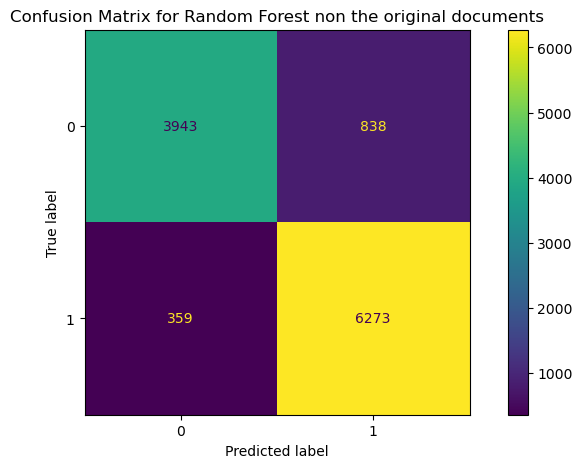

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test, ax=ax)

_ = ax.set_title(
    f"Confusion Matrix for Random Forest non the original documents"
)

In [67]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Probemos ahora este modelo sobre test.
y_pred_train = forest.predict(train_x)
y_pred_test = forest.predict(test_x)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(train_labels, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(test_labels, y_pred_test))

Exactitud sobre entrenamiento: 1.00
Exactitud sobre test: 0.90


In [ ]:
# ¿Overfitting?

In [69]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      4781
           1       0.88      0.95      0.91      6632

    accuracy                           0.90     11413
   macro avg       0.90      0.89      0.89     11413
weighted avg       0.90      0.90      0.89     11413



In [ ]:
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

In [ ]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [76]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [80]:
param_grid= {'criterion':['gini', 'entropy','log_loss'], 'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features':['auto', 'sqrt', 'log2']}

In [ ]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(forest, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(train_x, train_labels)

## Segunda iteración

In [ ]:
# La idea es seguir probando con metadatos de los textos